# Modelo LSTM

## Versión simple con una columna objetivo

In [86]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

Preparación de datos y procesamiento de texto

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def procesar_texto(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

def text_to_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

Definición de clase para generar el dataset con el que entrenará la red neuronal

In [123]:
class YouTubeCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, model):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.model = model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        embedding = text_to_embedding(text, self.model, self.tokenizer)
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

df = pd.read_csv('../database/toxic.csv')
df['Text'] = df['Text'].apply(procesar_texto)
X = df['Text'].tolist()
y = df['IsToxic'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

train_dataset = YouTubeCommentsDataset(X_train, y_train, tokenizer, bert_model)
test_dataset = YouTubeCommentsDataset(X_test, y_test, tokenizer, bert_model)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clase que define la red neuronal LSTM bidireccional

In [128]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because of bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # *2 because of bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # *2 because of bidirectional
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

Busqueda de hiperparametros con optuna

In [130]:
import optuna

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log = True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log = True)

    model = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epochs = 5  # Usar menos épocas para la búsqueda de hiperparámetros

    for epoch in range(num_epochs):
        model.train()
        for embeddings, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Crear un estudio de Optuna y optimizar la función de objetivo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Mostrar los mejores hiperparámetros encontrados
print('Best hyperparameters: ', study.best_params)

[I 2024-11-18 21:19:23,605] A new study created in memory with name: no-name-3df99717-1bec-4fca-850f-4287681e02d8
[I 2024-11-18 21:24:30,786] Trial 0 finished with value: 0.5533333333333333 and parameters: {'hidden_dim': 160, 'num_layers': 3, 'learning_rate': 8.281388626748556e-05, 'dropout_rate': 0.30418095495575725, 'weight_decay': 1.3457709589979254e-05}. Best is trial 0 with value: 0.5533333333333333.
[I 2024-11-18 21:29:32,654] Trial 1 finished with value: 0.7033333333333334 and parameters: {'hidden_dim': 173, 'num_layers': 3, 'learning_rate': 0.0005068274758806248, 'dropout_rate': 0.27985487370065376, 'weight_decay': 0.00035904373328086064}. Best is trial 1 with value: 0.7033333333333334.
e:\Bootcamp\NLP_Grupo3\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4216071572858765 and num_layers=1
  warnings.warn(
[I 2024-11-18 21:34

Best hyperparameters:  {'hidden_dim': 173, 'num_layers': 2, 'learning_rate': 0.0021176218278176036, 'dropout_rate': 0.44766068960506283, 'weight_decay': 0.00033437107177432967}


In [ ]:
input_dim = 768  # BERT embedding size
output_dim = 2  # Number of classes

best_params = study.best_params
model = BiLSTMModel(input_dim, best_params['hidden_dim'], output_dim, best_params['num_layers'], best_params['dropout_rate'])

In [132]:
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

num_epochs = 20

train_losses = []
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / len(test_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_bilstm_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

Epoch 1/20, Train Loss: 0.6915, Train Accuracy: 0.5186, Val Loss: 0.6574, Val Accuracy: 0.6867
Epoch 2/20, Train Loss: 0.6352, Train Accuracy: 0.6414, Val Loss: 0.5960, Val Accuracy: 0.6933
Epoch 3/20, Train Loss: 0.6207, Train Accuracy: 0.6586, Val Loss: 0.6336, Val Accuracy: 0.6533
Epoch 4/20, Train Loss: 0.5392, Train Accuracy: 0.7171, Val Loss: 0.6119, Val Accuracy: 0.6900
Epoch 5/20, Train Loss: 0.5297, Train Accuracy: 0.7343, Val Loss: 0.5731, Val Accuracy: 0.7100
Epoch 6/20, Train Loss: 0.4958, Train Accuracy: 0.7600, Val Loss: 0.5833, Val Accuracy: 0.6900
Epoch 7/20, Train Loss: 0.4736, Train Accuracy: 0.7800, Val Loss: 0.5694, Val Accuracy: 0.7100
Epoch 8/20, Train Loss: 0.4648, Train Accuracy: 0.7971, Val Loss: 0.6369, Val Accuracy: 0.6867
Epoch 9/20, Train Loss: 0.4526, Train Accuracy: 0.7914, Val Loss: 0.6109, Val Accuracy: 0.6800
Epoch 10/20, Train Loss: 0.4142, Train Accuracy: 0.8171, Val Loss: 0.6719, Val Accuracy: 0.6867
Epoch 11/20, Train Loss: 0.4425, Train Accuracy: 

Accuracy: 0.7233
Confusion Matrix:
[[128  38]
 [ 45  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       166
           1       0.70      0.66      0.68       134

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300



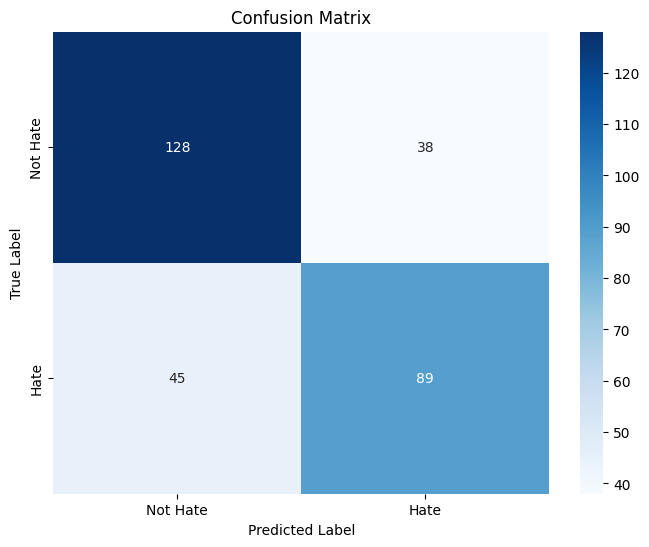

In [133]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [134]:
def test_texts(texts, model, tokenizer, bert_model):
    model.eval()
    processed_texts = [procesar_texto(text) for text in texts]
    embeddings = [text_to_embedding(text, bert_model, tokenizer) for text in processed_texts]
    embeddings = torch.tensor(embeddings, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(embeddings)
        _, preds = torch.max(outputs, 1)
    
    return preds.cpu().numpy()

In [155]:
texts = [
    "I love black people",
    "I hate black people",
]

# Obtener las predicciones
predictions = test_texts(texts, model, tokenizer, bert_model)

# Mostrar las predicciones
for text, pred in zip(texts, predictions):
    print(f'Text: {text}\nPrediction: {"Hate" if pred == 1 else "Not Hate"}\n')

Text: I love black people
Prediction: Not Hate

Text: I hate black people
Prediction: Hate



In [154]:
torch.save(model, 'final_bilstm_model_entire.pth')

---------